In [2]:
import pandas as pd
import numpy as np
import random
data=pd.read_csv("FAOLEX_ALL.csv")
print(data.keys())
np.random.seed(69)
random.seed(69)

Index(['Record Id', 'Record URL', 'Document URL', 'Title', 'Original title',
       'Date of original text', 'Last amended date', 'Available website',
       'Language of document', 'Country/Territory', 'Regional organizations',
       'Territorial subdivision', 'Type of text', 'Repealed', 'Abstract',
       'Primary subjects', 'Domain', 'Keywords'],
      dtype='object')


In [3]:
# remve repealed legislation
data["Repealed"].fillna(value = "N", inplace=True)
data["Repealed"] = pd.Categorical(data["Repealed"])
data=data[data["Repealed"]=="N"]

In [4]:
import random
import numpy as np
random.seed(69)
np.random.seed(69)
import pandas as pd
data=pd.read_csv("FAOLEX_All.csv")
print(data.keys())

Index(['Record Id', 'Record URL', 'Document URL', 'Title', 'Original title',
       'Date of original text', 'Last amended date', 'Available website',
       'Language of document', 'Country/Territory', 'Regional organizations',
       'Territorial subdivision', 'Type of text', 'Repealed', 'Abstract',
       'Primary subjects', 'Domain', 'Keywords'],
      dtype='object')


In [5]:
import nltk
keywords_nofilter=list(data["Keywords"])
country_nofilter=list(data["Country/Territory"])
i=0
# Split alle keywords op i en liste og ændrer nan til at være en str med Nan
for words in keywords_nofilter:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="NaN"
    if type(country_nofilter[i])!=str:
        country_nofilter[i]="NaN"
    keywords_nofilter[i]=words.split(";")
    i+=1



In [6]:
#Remove Nan from keywords and countries
keywords = []
country = []

for i in range(len(keywords_nofilter)):
    if keywords_nofilter[i] != ["NaN"] and country_nofilter[i]!="NaN":
        keywords.append(keywords_nofilter[i])
        country.append(country_nofilter[i])


# Top2vec topic model

In [7]:
# Make a top2vec topic model
from top2vec import Top2Vec
i=0
for word in keywords:
    keywords[i]="".join(word)
    i+=1
model = Top2Vec(keywords,embedding_model="doc2vec")



C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopyth

In [8]:
#model.generate_topic_wordcloud(0)


## Country co-occurence

- For hver tekst, find tilhørende topic --> noter landet til denne topic

In [9]:
# Compute unqie countries --> i.e. remove agreement "countries" 
country_new=[]
for coun in country:
    if len(coun.split(";"))>=2:
        for c in coun.split("; "):
            country_new.append(c)
    else:
        country_new.append(coun)

In [10]:
# Make country dict --> key: country, value: country index
countries = {}
i=0
for country_x in (list(set(country_new))):
    countries[country_x]=i
    i+=1

In [11]:
# Compute country co-occurence matrix
topic_sizes, topic_nums = model.get_topic_sizes()

country_topic_matrix = np.zeros((len(set(country_new)),len(topic_nums)))

for num in topic_nums:
    # For each topic get the corresponding documents
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=num,num_docs=topic_sizes[num])
    for id in document_ids:
        # Find the documents' countries and add it to the co-occurence matrix
        if len(country[id].split(";"))>=2:
            for c in country[id].split("; "):
                 country_topic_matrix[countries[c],num] +=1
        else:
            country_topic_matrix[countries[country[id]],num] +=1



In [12]:
def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)


In [16]:

def square_rooted(x):
        return np.sqrt(sum([a*a for a in x]))
def co_occurence(country_new,similarity):
    country_co_occurrence = np.zeros((len(set(country_new)),len(set(country_new))))

    for i in range(len(set(country_new))):
        for j in range(len(set(country_new))):
            if similarity == "correlation":
                # Correlation
                country_co_occurrence[i,j] = np.exp(np.corrcoef(country_topic_matrix[i,:],country_topic_matrix[j,:])[0,1])/np.exp(1)
            elif similarity == "cosine":
                #Cosine similarity:
                country_co_occurrence[i,j] = country_topic_matrix[i,:]@country_topic_matrix[j,:]/(square_rooted(country_topic_matrix[i,:])*square_rooted(country_topic_matrix[j,:]))
            elif similarity == "euclidean":
                # Eucledean distance
                country_co_occurrence[i,j] = np.linalg.norm(country_topic_matrix[i,:]-country_topic_matrix[j,:])
    if similarity == "euclidean":
        country_co_occurrence=1-(country_co_occurrence/np.max(country_co_occurrence))

    return country_co_occurrence

country_co_occurrence = co_occurence(country_new,"correlation")
np.shape(country_co_occurrence)

(257, 257)

Country Network


In [17]:
# swap dict
def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)

print(countries_swap)


{0: 'China, Hong Kong SAR', 1: 'Maldives', 2: 'Namibia', 3: 'Netherlands Antilles (Netherlands)', 4: 'Zanzibar (United Republic of Tanzania)', 5: 'Ghana', 6: 'Falkland Islands (Malvinas)', 7: 'Guatemala', 8: 'South Africa', 9: 'Lebanon', 10: 'Madeira Islands (Portugal)', 11: 'Bonaire, Sint Eustatius and Saba (Netherlands)', 12: 'Pitcairn (UK)', 13: 'Montserrat (UK)', 14: 'El Salvador', 15: 'Saint Martin (France)', 16: 'United Kingdom of Great Britain and Northern Ireland', 17: 'Albania', 18: 'Hungary', 19: 'Glorioso Island (France)', 20: 'Estonia', 21: 'French Guiana (France)', 22: 'Cook Islands', 23: 'Guinea', 24: 'Solomon Islands', 25: 'Armenia', 26: 'Syrian Arab Republic', 27: 'Palau', 28: 'Philippines', 29: 'Thailand', 30: 'Bangladesh', 31: 'Uganda', 32: 'Gibraltar (UK)', 33: 'Congo', 34: 'Türkiye', 35: 'Saint Barthélemy (FRA)', 36: 'Åland Islands (Finland)', 37: 'Qatar', 38: 'Anguilla (UK)', 39: 'South Sudan', 40: 'Suriname', 41: 'Palestine', 42: 'Russian Federation', 43: 'Republi

In [18]:
#Remove small countries/islands
for i in range(len(set(country_new))):
    if country_new.count(countries_swap[i])<=50:
        country_co_occurrence[i] =0
        country_co_occurrence[:,i]=0

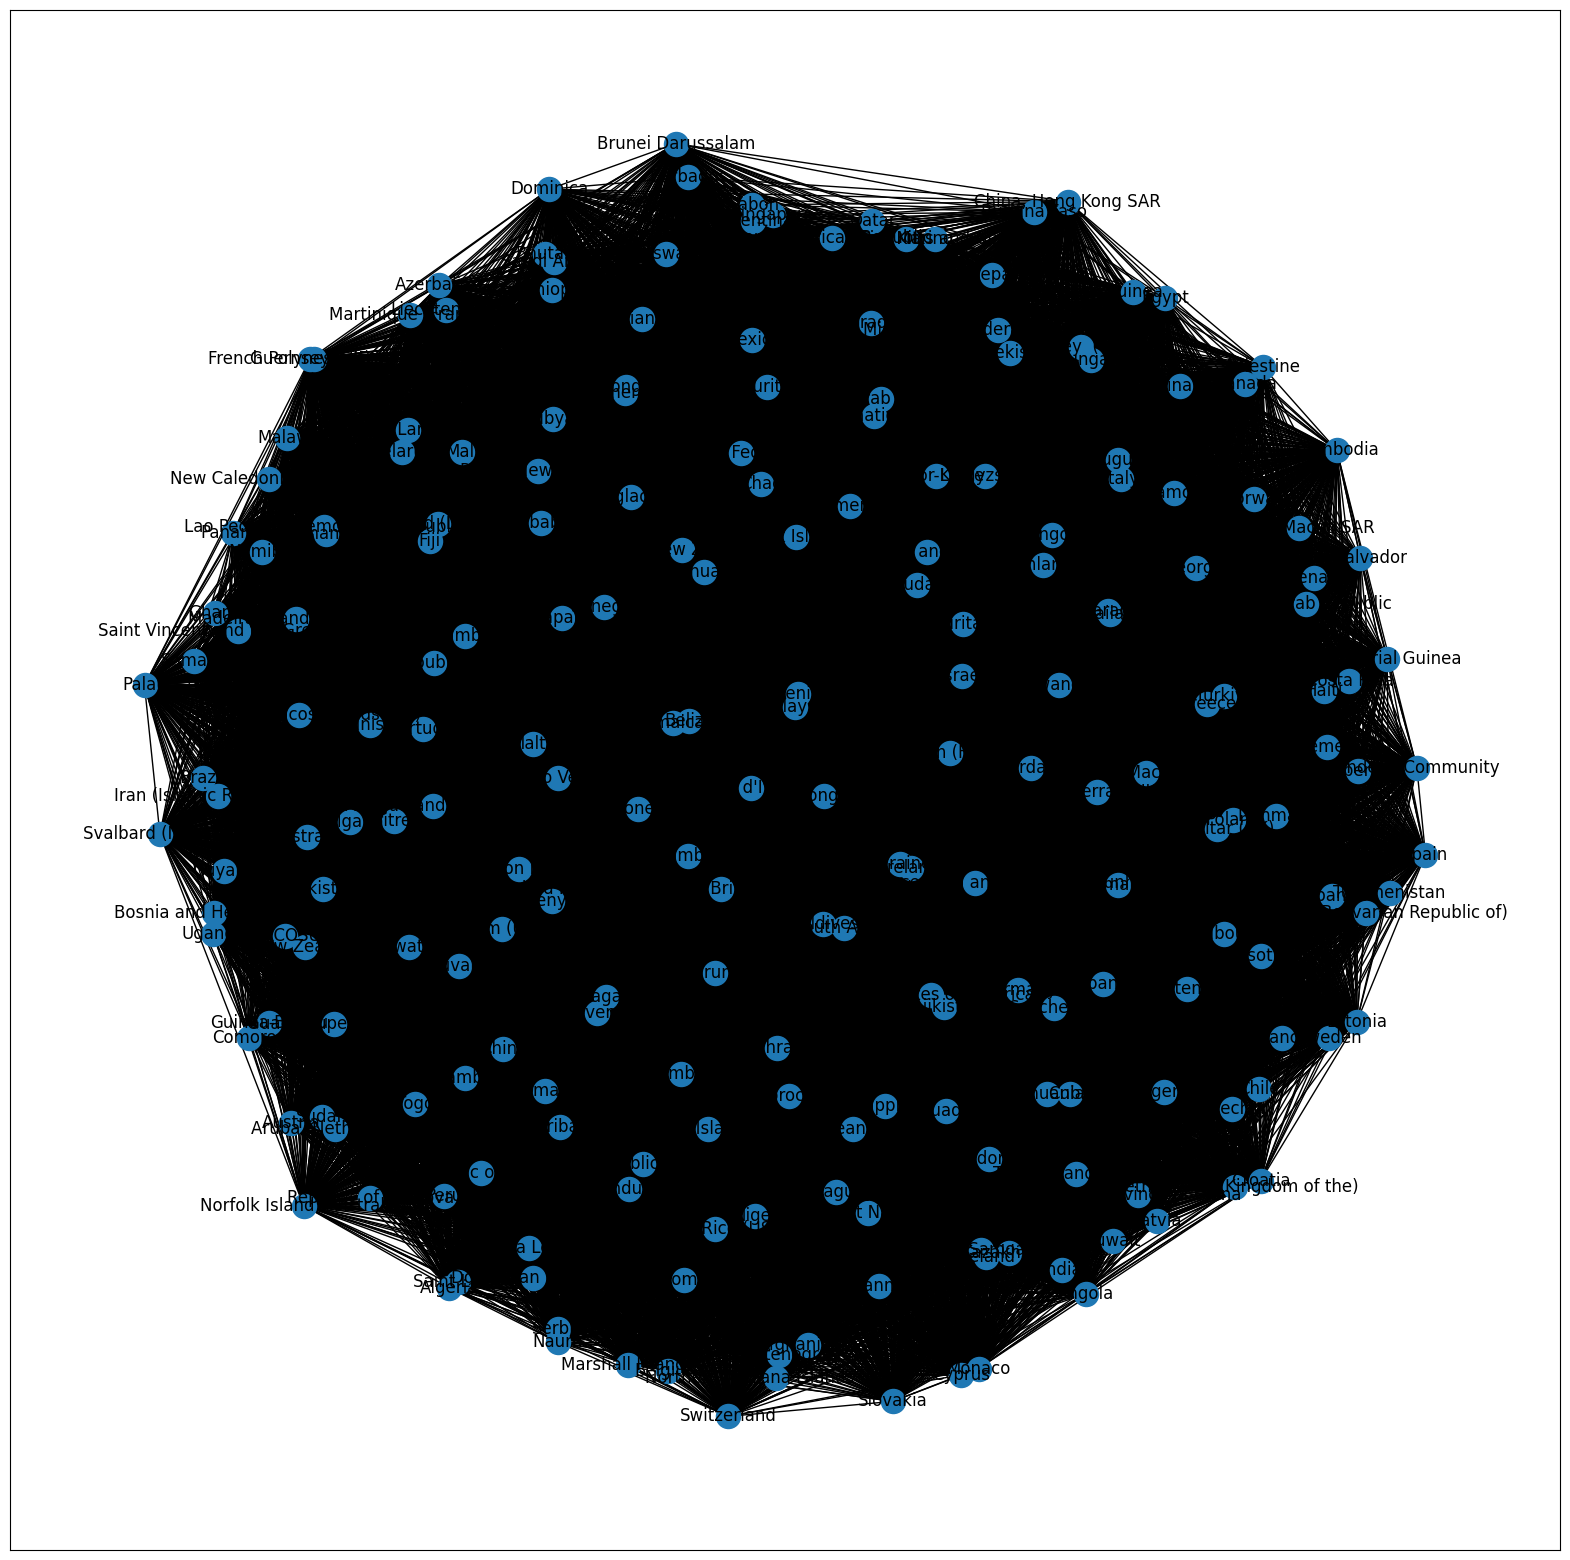

In [19]:

from networkx.algorithms.community import girvan_newman
import networkx as nx
import itertools
import matplotlib.pyplot as plt

G = nx.Graph()

size = country_co_occurrence.shape[0]
countries_swap_copy = countries_swap.copy()

G.add_nodes_from(range(size))

#Adding the weighted edges between the nodes
for i in range(size):
        for j in range(i+1, size):
            if country_co_occurrence[i, j] != 0.0:
            #if country_co_ocurrence[i, j] > 0.15:
                G.add_edge(i, j, weight=country_co_occurrence[i, j])

#removing the small nodes without co-occurrence
for i in range(size):
    if np.sum(country_co_occurrence[i])==0:
        G.remove_node(i)
        countries_swap_copy.pop(i)

plt.figure(figsize=(20, 20))
nx.draw_networkx(G, labels=countries_swap_copy,with_labels=True)
#nx.draw_spring(G, labels=countries_swap,with_labels=True)

In [ ]:
#Louvain method

In [23]:
#hej
from networkx.algorithms.community import louvain_communities
comms = louvain_communities(G,weight="weight",resolution=1.1,seed=69)
unique_coms = np.unique(list(comms))


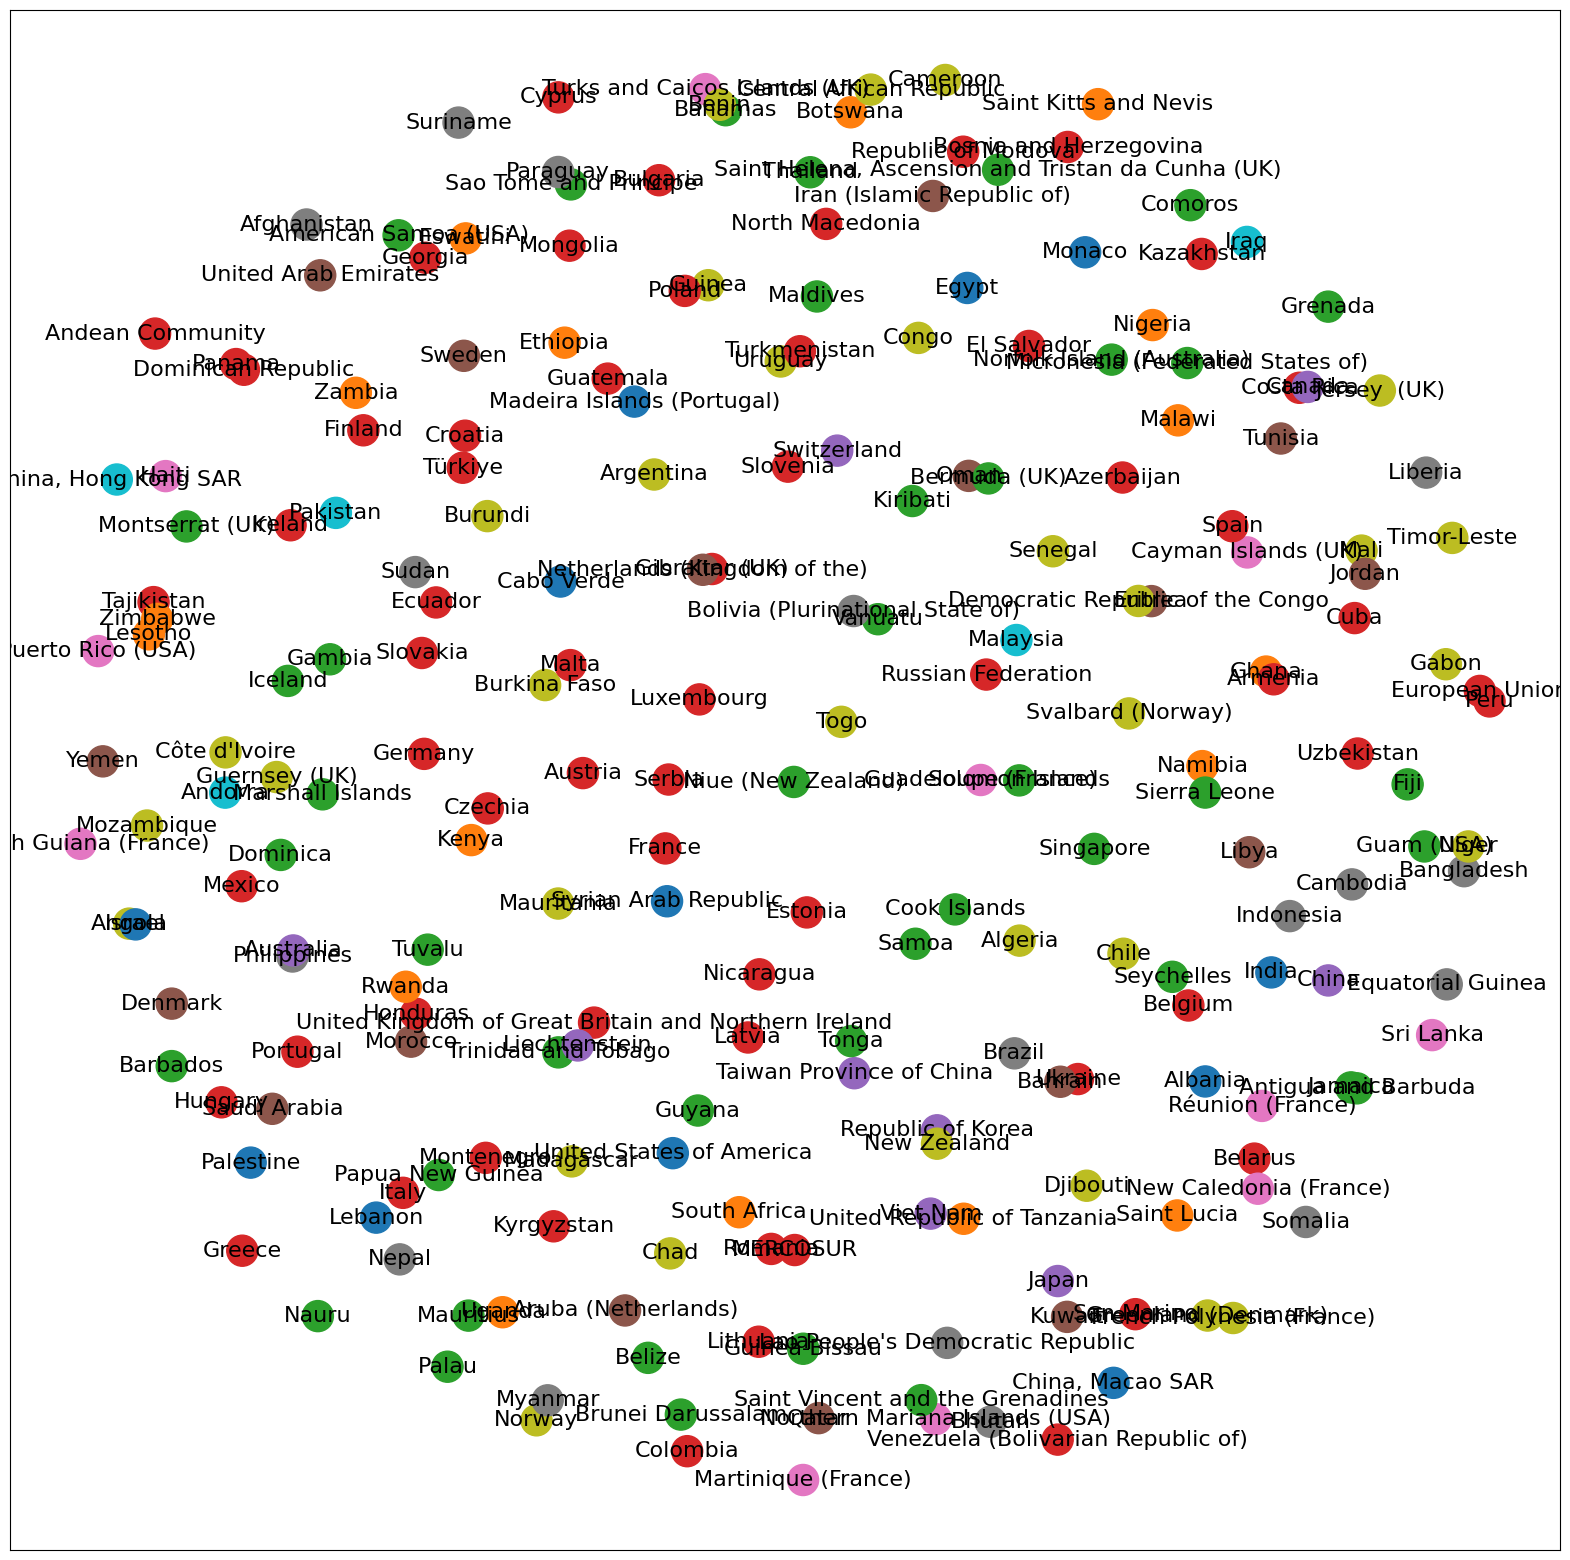

In [24]:
community_assignment = {}

# Assign community indices to nodes
for i, community in enumerate(comms):
    for node in community:
        community_assignment[node] = i

# Create a list of colors for each node based on the community assignment
node_colors = [community_assignment.get(node, -1) for node in G.nodes()]




# Draw the graph with different colors for different communities
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G)  # Positions of nodes in the graph layout
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=500)
#nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos,labels=countries_swap_copy,font_size=16 )
plt.show()

In [25]:
i=1

for community in comms:
    print("c",i)
    for country in community:
        print(countries_swap_copy[country])

    i=i+1

c 1
Albania
Cabo Verde
Madeira Islands (Portugal)
Monaco
China, Macao SAR
c 2
Israel
Lebanon
Syrian Arab Republic
Egypt
c 3
United States of America
Palestine
India
c 4
South Africa
Nigeria
c 5
Botswana
Rwanda
Zambia
Namibia
Ghana
Ethiopia
Zimbabwe
Malawi
Lesotho
United Republic of Tanzania
Eswatini
Kenya
Uganda
c 6
Saint Lucia
Saint Kitts and Nevis
c 7
Barbados
Grenada
Norfolk Island (Australia)
Mauritius
Antigua and Barbuda
Trinidad and Tobago
Belize
Jamaica
Montserrat (UK)
Saint Vincent and the Grenadines
Guam (USA)
Bahamas
Tonga
American Samoa (USA)
Guyana
Dominica
Bermuda (UK)
c 8
Singapore
Brunei Darussalam
c 9
Maldives
Sao Tome and Principe
Iceland
Tuvalu
Guinea-Bissau
Nauru
Seychelles
Cook Islands
Solomon Islands
Vanuatu
Palau
Marshall Islands
Thailand
Samoa
Niue (New Zealand)
Fiji
Gambia
Papua New Guinea
Sierra Leone
Comoros
Micronesia (Federated States of)
Kiribati
Saint Helena, Ascension and Tristan da Cunha (UK)
c 10
Serbia
Italy
North Macedonia
Czechia
Slovenia
Finland
Uni

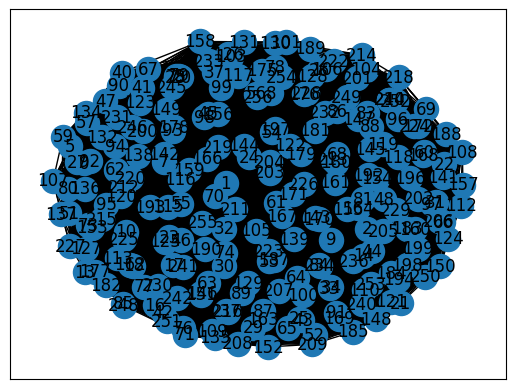

In [26]:
# saving graph created above in gexf format
F = G.copy()


for node_id, label in countries_swap_copy.items():
    F.nodes[node_id]['label'] = label


nx.draw_networkx(F)



In [29]:
#F_com = nx.algorithms.community.label_propagation_communities(F,weight="weight",resolution=2,seed=69)
F_com = louvain_communities(F,weight="weight",resolution=1.1,seed=69)
for i, community in enumerate(F_com):
    for node in community:
        F.nodes[node]['community'] = i


In [30]:
#make a file for gephi
nx.write_gexf(F, "test5.gexf")